In [1]:
from scipy.fft import fft
from scipy.linalg import expm
import time
import random
import json
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as ss
from scipy.optimize import minimize
from entforg import *
from IPython.display import display,Markdown,Latex


from qiskit.primitives import StatevectorEstimator
from qiskit import transpile
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.synthesis import MatrixExponential, LieTrotter
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from itertools import product
import math

from qiskit.quantum_info.operators import Pauli
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper

from collections import defaultdict 
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from IPython.display import display
ME = MatrixExponential()

!!!!!!!!!!!!!!!!!!!!

El objetivo de este notebook es comprobar si el orden de las energías obtenido para la parte cuadrática del hamiltoniano se mantiene al reintroducir el término cuártico o se entrecruzan. Para ello, vamos reintroduciendo este término mediante un parámetro alpha entre 0 y 1.

!!!!!!!!!!!!!!!!!!!!

### Definimos las distintas funciones que nos permitirán llevar a cabo las optimizaciones.

In [2]:
# Estas son funciones para visualizar de una forma más agradable las matrices resultantes.
def MatrixToLatex(A):
    a="\\begin{bmatrix}"
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if ((j+1)%A.shape[1])==0:           
                a=a+"{0:.2f}".format(A[i,j])
            else:
                a=a+"%s&"%"{0:.2f}".format(A[i,j])
        if ((i+1)%A.shape[0])!=0:
            a=a+"\\\\"
    a=a+"\\end{bmatrix}"

    return(a)

def Display(string):
    display(Markdown(string))

    
def DisplayMatrix(A):
    A_Latex = MatrixToLatex(A)
    display(Markdown(A_Latex))

In [3]:
# Esta función calcula el hamiltoniano del problema, dados los valores de los shifts y el offset en ppm, de los J en Hz y de B en MHz. 
def Hspin(shifts, J, offset, B):
    # Leemos cuantos spines hay en el sistema.
    n=len(shifts)
    # Definimos los coeficientes que acompañarán a las cadenas de Pauli.
    w=[(shifts[i]-offset)*np.pi*B for i in range(n)]
    J2=[np.pi*J[i]/2 for i in range(len(J))]
    # Creamos las listas que guardarán los datos.
    pauli_strings = []
    coeffs=[]
    # Añadimos los términos correspondientes a los shifts.
    for i in range(n):
        string='I'*i+'Z'+'I'*(n-i-1)
        pauli_strings.append(string)
        coeffs.append(w[i])
    # Añadimos los términos correspondientes a los J.
    k=0
    for i in range(n):
        for j in range(n-i-1):
            strX='I'*i+'X'+'I'*j+'X'+'I'*(n-i-j-2)
            strY='I'*i+'Y'+'I'*j+'Y'+'I'*(n-i-j-2)
            strZ='I'*i+'Z'+'I'*j+'Z'+'I'*(n-i-j-2)
            pauli_strings.append(strX)
            coeffs.append(J2[k])
            pauli_strings.append(strY)
            coeffs.append(J2[k])
            pauli_strings.append(strZ)
            coeffs.append(J2[k])
            k+=1
    # Creamos y devolvemos el operador equivalente en la base de Pauli
    return SparsePauliOp.from_list(list(zip(pauli_strings, coeffs)))            

In [4]:
# Función necesaria para transformar los nombres de los elementos del diccionario que guarda la descomposición en operadores fermiónicos.
def transform_dict_keys(data):
    label_transformation = {
        "I": "",
        "N": "+_{} -_{}",
        "E": "-_{} +_{}",
        "+": "+_{}",
        "-": "-_{}",
    }

    new_data = {}
    for key, value in data.items():
        new_key_parts = []
        for i, char in enumerate(key):
            if char in label_transformation:
                # Apply transformation if the character is in the mapping
                transformed = label_transformation[char].format(i, i)
                if transformed:
                    new_key_parts.append(transformed)
        new_key = ' '.join(new_key_parts)  # Join the parts with spaces
        new_data[new_key] = value

    return new_data

# Función que transforma un operador descompuesto en cadenas de Pauli en un operador en la base fermiónica. 
# Aplica la transformación de Jordan-Wigner inversa.
def reverse_map(second_q_op: SparsePauliOp) -> FermionicOp:
        """Maps a class:`OperatorBase` to a `FermionicOp`.

        Args:
            second_q_op: the :class:`OperatorBase` to be mapped.

        Returns:
            The `FermionicOp` corresponding to the Hamiltonian in the Fermionic space.
        """

        num_qubits = second_q_op.num_qubits # get number of qubits from input second quantized operator
        fermionic_op = None
        for term in second_q_op:
            transform_list : List[Tuple(str, float)] = []  # list of tuple(pauli, coeff)
            coef_term = term.coeffs[0]  # Assuming coeffs is a list with a single element
            target_pauli_op = term.paulis[0]
            #print(target_pauli_op)

            for i in range(num_qubits):
                one_pauli = target_pauli_op[num_qubits - 1 - i]
                pauli_char=one_pauli.to_label()
                if pauli_char == 'Z': # dealing Pauli Z op
                    transform_list.append((('I',1),('N', -2))) # Zj -> I - 2*Nj => [('I', 1), ('N', -2)]
                elif pauli_char == 'X': # dealing Pauli X op
                    transform_list.append((("+", 1), ('-', 1))) # Xj -> aj_dag + aj => [('+', 1), ('-', 1)]
                    target_pauli_op &= Pauli("I" * (i+1) + "Z" * (num_qubits - i - 1)) # apply Z(j-1)Z(j-2) ... Z(0)
                elif one_pauli.to_label() == 'Y': # dealing Pauli Y op
                    transform_list.append((('+', 1j), ('-', -1j))) # Yj -> i(aj - aj_dag) => [('+', -1j), ('-', 1j)]
                    target_pauli_op &= Pauli("I" * (i+1) + "Z" * (num_qubits - i - 1)) # apply Z(j-1)Z(j-2) ... Z(0)
                else: 
                    # dealing Pauli I op
                    transform_list.append((('I', 0.5), ('I', 0.5))) # Ij -> Ij => [('I', 0.5), ('I', 0.5)]; split I into 0.5I + 0.5I for code consistency
            
            # dealing the phase
            if target_pauli_op.phase == 1:
                coef_term *= 1j
            elif target_pauli_op.phase == 2:
                coef_term *= -1
            elif target_pauli_op.phase == 3:
                coef_term *= -1j

            #print(transform_list)
            pauli_coefs = []
            pauli_strings = []
            # create fermionic operator for a term based on transform_list
            for idxes in product(*[[0, 1]]*num_qubits):
                pauli_coefs.append(math.prod([t[i][1] for t, i in zip(transform_list, idxes)]))
                pauli_strings.append("".join([t[i][0] for t, i in zip(transform_list, idxes)])[::-1])
            ferm_op=list(zip(pauli_strings, pauli_coefs))

            ferm_dict = defaultdict(float)

            # Iterate over each tuple in the list
            for key, value in ferm_op:
                # Sum the float values for tuples with the same string
                ferm_dict[key] += value

            ferm_dict_sparse=transform_dict_keys(ferm_dict)

            #print(ferm_dict)
            #print(ferm_dict_sparse)
            #print(coef_term)

            if not fermionic_op:
                fermionic_op = coef_term * FermionicOp(ferm_dict_sparse,num_spin_orbitals=num_qubits).simplify()
            else:
                fermionic_op += coef_term * FermionicOp(ferm_dict_sparse,num_spin_orbitals=num_qubits).simplify()

        return fermionic_op.simplify()

# Función que filtra los términos con dos operadores fermiónicos.
def filter_two_operator_terms(fermionic_op):
    """
    Filtra los términos con exactamente dos operadores del FermionicOp.

    Args:
        fermionic_op (FermionicOp): El operador fermiónico a filtrar.

    Returns:
        FermionicOp: Un nuevo FermionicOp con solo los términos de dos operadores.
    """
    filtered_data = {
        term: coeff
        for term, coeff in fermionic_op.items()
        if len(term.split()) == 2 or len(term.split())==0   # Solo términos con dos operadores
    }
    return FermionicOp(filtered_data, num_spin_orbitals=fermionic_op.num_spin_orbitals)

In [5]:
# Función que realiza el cambio de base del operador fermiónico, dada una matriz de cambio de base T.
def transform_fermionic_op(fermionic_op, T, T_conj):
    new_op_data = {}
    
    for term, coeff in fermionic_op.items():
        # Ignorar el término constante
        if term == '':
            new_op_data[''] = coeff
            continue
        
        # Expandir cada término en la nueva base
        new_terms = {}
        for t in term.split():
            op, idx = t[0], int(t[2])
            if op == '+':  # Transformación de operadores de creación
                new_operators = {f'+_{j}': T[j, idx] for j in range(len(T))}
            elif op == '-':  # Transformación de operadores de destrucción
                new_operators = {f'-_{j}': T_conj[j, idx] for j in range(len(T_conj))}
            
            # Combinar términos en la nueva base
            if not new_terms: # Si este término no existía, simplemente se guarda el nuevo.
                new_terms = new_operators
            else: # Si existía, se combinan los antiguos con los nuevos de esta iteración.
                new_terms = {
                    f"{k1} {k2}": v1 * v2
                    for k1, v1 in new_terms.items()
                    for k2, v2 in new_operators.items()
                }
        
        # Agregar al nuevo FermionicOp
        for new_term, new_coeff in new_terms.items():
            if new_term in new_op_data:
                new_op_data[new_term] += coeff * new_coeff
            else:
                new_op_data[new_term] = coeff * new_coeff

    return FermionicOp(new_op_data, num_spin_orbitals=len(T))


In [6]:
def filter_single_z_terms(sparse_pauli_op):
    """
    Filtra los términos en un SparsePauliOp que contienen exactamente una 'Z' y el resto son identidades ('I').

    Args:
        sparse_pauli_op (SparsePauliOp): El SparsePauliOp a filtrar.

    Returns:
        SparsePauliOp: Un nuevo SparsePauliOp con los términos filtrados.
    """
    pauli_strings = sparse_pauli_op.paulis.to_labels()
    coeffs = sparse_pauli_op.coeffs

    # Filtrar términos con exactamente una 'Z' y el resto 'I'
    filtered_pauli_strings = []
    filtered_coeffs = []
    
    for pauli, coeff in zip(pauli_strings, coeffs):
        if pauli.count('Z') == 1 and pauli.count('I') == len(pauli) - 1:
            filtered_pauli_strings.append(pauli)
            filtered_coeffs.append(coeff)
        if pauli.count('I') == len(pauli):
            filtered_pauli_strings.append(pauli)
            filtered_coeffs.append(coeff)

    # Crear y devolver el nuevo SparsePauliOp con los términos filtrados
    return SparsePauliOp.from_list(list(zip(filtered_pauli_strings, filtered_coeffs)))

In [7]:
# Función que calcula el valor esperado de la energía del hamiltoniano total.
def expectation_classic(x, ansatz_U, beta, H_matrix, H_tot_matrix, cllbck = None):
    U_bound = ansatz_U.assign_parameters(x) # Dado un vector de parámetros, los asigna al operador unitario equivalente al circuito.
    U_matrix = Operator(U_bound).data # Obtenemos la matriz de este operador.

    # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
    qclist=[]
    n=len(U_matrix)
    N_sites=int(np.log2(n))
    obs=SparsePauliOp.from_operator(Operator(H_matrix))
    Energies=np.zeros(n)
    for j in range(n):
        state0=np.zeros(n)

        state0[j]=1

        statenew=U_matrix@state0
        Energies[j]=np.real(np.dot(np.conj(statenew),np.dot(obs,statenew)))
    
    # Obtenemos el TFD a partir de estas energías y de la matriz U.
    TFD, _ = get_TFD(beta, U_matrix, np.conj(U_matrix), Energies)
    sTFD = ss.csr_matrix(TFD)
    # Obtenemos el valor esperado de la energía del hamiltoniano total en el estado dado por el TFD obtenido.
    total_energy = np.real(np.dot(np.conj(sTFD), np.dot(H_tot_matrix, sTFD.T)))[0,0]
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return total_energy
    
def callback(x):
    global x_arr
    x_arr.append(x)

# Función que calcula el valor de la energía libre.
def free_energy(x, ansatz_U, beta, H_matrix, H_tot_matrix, cllbck = None):
    U_bound = ansatz_U.assign_parameters(x) # Dado un vector de parámetros, los asigna al operador unitario equivalente al circuito.
    U_matrix = Operator(U_bound).data # Obtenemos la matriz de este operador.

    # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
    qclist=[]
    n=len(U_matrix)
    N_sites=int(np.log2(n))
    obs=SparsePauliOp.from_operator(Operator(H_matrix))
    Energies=np.zeros(n)
    for j in range(n):
        state0=np.zeros(n)

        state0[j]=1

        statenew=U_matrix@state0
        Energies[j]=np.real(np.dot(np.conj(statenew),np.dot(obs,statenew)))
        
    # Obtenemos el valor de la energía libre.
    energia_libre=-sum(np.exp(-beta*Energies))/beta
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return energia_libre

In [8]:
# Función que crea el circuito que usamos como ansatz.
def ansatz_U(qubit_op,N_sites, reps=1):
    ansatz_U = QuantumCircuit(N_sites) # Creamos nuestro circuito de N spines
    # Obtenemos los grupos de conmutación de nuestro operador de espines, así como los términos con un solo operador Z.
    groups=qubit_op.group_commuting()
    group_cuadratic=filter_single_z_terms(qubit_op)
    count = 0

    # Aplicamos tantas repeticiones como se nos diga del circuito. Primero, se aplican bloques correspondientes a todos los grupos de conmutación
    # y, después, se aplica un bloque extra correspondiente a los términos con un solo operador Z.
    for r in range(reps):
        for d in range(len(groups)):
            ansatz_U.append(PauliEvolutionGate(groups[len(groups)-d-1], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
            count += 1
        ansatz_U.append(PauliEvolutionGate(group_cuadratic, Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
        count += 1
    return ansatz_U

In [9]:
# Clases que nos permitirán representar el espectro, proporcionadas por Mestrelab.
class SpinSystem:
  def __init__(self):
    self.nucs = []
    self.jlist = []
    self.level =1
    
  def addNuc(self,name,shift):
      tn = nucleus(name,shift);
      self.nucs.append(tn)
      
  def addJ(self,name1,name2,j):
      tn = coupling(name1,name2,j);
      self.jlist.append(tn)
    
class nucleus:
    def __init__(self,name,shift):
      self.name = name
      self.shift = shift
      
class coupling:
    def __init__(self,name1,name2,j):
      self.name1 = name1
      self.name2=name2
      self.j = j
        
class NMRSimulator:
    E= np.matrix([[1, 0],[0, 1]])
    Ix = np.matrix([[0, 1/2],[1/2, 0]])
    Iy= np.matrix([[0, -1J/2], [1J/2, 0]])
    Iz = np.matrix([[1/2,0],[0,-1/2]])   
      
    def __init__(self):
      #std operators        
  

      # SET SIM parameters here
      self.field =400   
      self.swp = 10
      self.setOffsetPPM( 5)
      self.setTD(2**14)
      self.setT2(2);
      self.debug=False
      #self.noise=1/2000
      self.nucleus="1H"
      
    def setField(self,field):
        self.field=field
        self.offsetH = self.offset*self.field
        
    def setSWPPM(self,swp): 
        self.swp=swp
        self.swh=swp*self.field
        self.dw=1/self.swh
        
    def setOffsetPPM(self,offset):
        self.offset=offset
        self.offsetH = self.offset*self.field
        
    def setTD(self,td):
        self.td=int(td)
        
    def setT2(self, t2):
        self.t2=t2
      
    def getOperator (op, n):
        for i in range(n):
            if i==0:
                h=op
            else:
                h=NMRSimulator.E
            for j in range (1,n):
                if i==j:
                    h2=op
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            if(i==0):
                H=h
            else:
                H=H+h
        return H;
    
      
    def makeHamiltonian(self, ss):
        for n in ss.nucs:
            ind = ss.nucs.index(n)
            #print('nuc ' + n.name + ' ' +  str(ind))
            if ind==0:
                h=NMRSimulator.Iz
            else:
                h=NMRSimulator.E
            for i in range (1,len(ss.nucs)):
                if ind==i:
                    h2=NMRSimulator.Iz
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            h = h * np.pi*2 * (n.shift * self.field - self.offsetH)
            if(ind==0):
                H=h
            else:
                H=H+h
            
        #print('done nucs')
        for j in ss.jlist:
            ind1 = NMRSimulator.getIndexForName(j.name1, ss.nucs)
            ind2 = NMRSimulator.getIndexForName(j.name2, ss.nucs)
            #print (str(ind1) + '   ' + str(ind2))
            if ind1==0 or ind2==0:
                hx=NMRSimulator.Ix
                hy=NMRSimulator.Iy
                hz=NMRSimulator.Iz
                #print('ind0 hx')
            else:
                hx=NMRSimulator.E
                hy=NMRSimulator.E
                hz=NMRSimulator.E
                #print('ind0 E')
            for i in range (1,len(ss.nucs)):
                if ind1==i or ind2==i:
                    hx2=NMRSimulator.Ix
                    hy2=NMRSimulator.Iy
                    hz2=NMRSimulator.Iz
                    #print('indi hx')
                else:
                    hx2=NMRSimulator.E
                    hy2=NMRSimulator.E
                    hz2=NMRSimulator.E
                    #print('indi E')
                hx=np.kron(hx,hx2)
                hy=np.kron(hy,hy2)
                hz=np.kron(hz,hz2)
            H= H + 2*np.pi*j.j*(hx + hy + hz)
        return H

    def getIndexForName(name, nucs):
        for l in nucs:
            ind = nucs.index(l)
            if(l.name == name):
                return ind;
        

        
    def simSpinSystem(self, ss):
        H = self.makeHamiltonian(ss)
        m0 = NMRSimulator.getOperator(NMRSimulator.Ix,len(ss.nucs))
        IxT = m0
        IyT = NMRSimulator.getOperator(NMRSimulator.Iy,len(ss.nucs))
        vals,vecs = LA.eigh(H)
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)

        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi @ m0 @ vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm =  vecs @ expm(-1J * t[x] * diag) @ mMat @ expm(1J * t[x] * diag) @ vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.real(np.trace(tm*IxT) * fac2)
            fidi[x] = np.real(np.trace(tm*IyT) * fac2)
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
    def simSpinSystemQuantum(self, ss, vals, vecs, m_x, m_y):
    
        m0 = m_x
        IxT = m_x
        IyT = m_y
        
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)
        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi @ m0 @ vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm = vecs @ expm(-1J * t[x] * diag) @ mMat @ expm(1J * t[x] * diag) @ vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.real(np.trace(tm @ IxT) * fac2)
            fidi[x] = np.real(np.trace(tm @ IyT) * fac2)
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
#    def getNoise(self):
#        u = random.random(); 
#        v = random.random();
#        return math.sqrt(-2.0 * math.log(u)) * math.cos(2.0 * np.pi * v) * self.noise;
#    
#    def addNoise(self,re,im):
#        for i in range(len(re)):
#            re[i]=re[i]+self.getNoise()
#            im[i]=im[i]+self.getNoise()

    def simSpectrum(self, sss, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystem(ss)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=np.real(spc[i])
            spcOut[i] =np.real(spc[td2+i])
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs
    
    def simSpectrumQuantum(self, sss, vals, vecs, m_x, m_y, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystemQuantum(ss, vals, vecs, m_x, m_y)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=np.real(spc[i])
            spcOut[i] = np.real(spc[td2+i])
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs

In [10]:
# Funciones que nos permitirán crear la magnetizacion.
def local_spin_x(N_sites):
    ham=[]
    for i in range(0,N_sites):
        string='I'*i+'X'+'I'*(N_sites-1-i)
        ham.append(string)
    return ham

def local_spin_y(N_sites):
    ham=[]
    for i in range(0,N_sites):
        string='I'*i+'Y'+'I'*(N_sites-1-i)
        ham.append(string)
    return ham

In [11]:
# Función que transforma la magnetización según la matriz dada por la transformada de Bogoliubov.
def transform_M(T,Mx,My):
    T_conj=T
    # Transformamos la matrix dada a operadores fermiónicos mediante una Jordan-Wigner inversa.
    mag_fx=reverse_map(Mx)
    mag_fy=reverse_map(My)
    
    mag_new_x=transform_fermionic_op(mag_fx,T,T_conj)
    mag_new_y=transform_fermionic_op(mag_fy,T,T_conj)
    # Aplicamos una transformación de Jordan-Wigner sobre el operador fermiónico transformado para devolverlo a su expresión en operadores de espín.
    mag_mom_x=JW.map(mag_new_x.simplify()).chop(1e-6)
    mag_mom_y=JW.map(mag_new_y.simplify()).chop(1e-6)
    return mag_mom_x,mag_mom_y#, mag_fy

In [12]:
# Definimos la función que representa el espectro obtenido frente al teórico.
def reprSpectrum(shifts,J,d,SW,B,offset,energ,U,T,xlim=None,ylim=None,reprteo=True):
    # Construimos el SpinSystem asociado, añadiendo los shifts primero y los acoplamientos J después.
    sscase = SpinSystem()
    n=len(shifts)
    for i in range(n):
        sscase.addNuc(str(i), shifts[i])
    k=0
    for i in range(n):
        for j in range(i+1,n):
            sscase.addJ(str(i), str(j), J[k])
            k+=1
    sscase.level=1

    # Construimos las matrices de las magnetizaciones
    m_x=SparsePauliOp(local_spin_x(n),coeffs=0.5)
    m_y=SparsePauliOp(local_spin_y(n),coeffs=0.5)

    # Transformamos las matrices a la base correspondiente.
    mag_x, mag_y=transform_M(T,m_x,m_y)
    
    # Construimos el simulador NMR
    nmrsim = NMRSimulator()
    nmrsim.setField(B)
    nmrsim.setTD(d) # Resolución del espectro
    nmrsim.setSWPPM(SW) # Ancho espectral
    nmrsim.setOffsetPPM(offset)
    nmrsim.setT2(2.0)
    sss = []
    sss.append(sscase)
    # Calculamos el espectro a partir de las energías y la matriz U dadas
    spcOut, fs, v, w = nmrsim.simSpectrumQuantum(sss, energ, U, mag_x.to_matrix(),mag_y.to_matrix())
    # Calculamos el espectro teórico
    spcOutteo, fsteo, v, w= nmrsim.simSpectrum(sss)
    # Representamos ambos espectros para comparar.
    if reprteo:
        plt.plot(fsteo, spcOutteo,'-', label='Theoretical Spectrum', color='red',lw=2)
    plt.plot(fs, spcOut, '-', label='Experimental Spectrum', color='black',alpha=0.8)
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.legend()
    plt.show()

In [13]:
# Función que realiza la minimización para un hamiltoniano dado (en base de espines) y unos valores de beta. 
# La función que se minimiza puede escogerse con el argumento function.
def minimize_function(H, function, betas, alpha):

    # Obtenemos el número de espines correspondiente al hamiltoniano dado.
    N_sites=H.num_qubits
    # Transformamos la descomposición obtenida a operadores fermiónicos mediante una Jordan-Wigner inversa.
    fermionic_op= reverse_map(H)


    # Creamos la matriz que guardará los coeficientes de la parte cuadrática del operador fermiónico. 
    num_spin_orbitals = fermionic_op.num_spin_orbitals
    h1 = np.zeros((num_spin_orbitals, num_spin_orbitals), dtype=np.complex128)
    
    # Extraemos términos cuadráticos.
    for term, coeff in fermionic_op.items():
        if term.count('+') == 1 and term.count('-') == 1:  # Verifica que tenga un operador de creación y uno de destrucción
            # Extraer los índices y los signos de los operadores
            indices = [int(t[2]) for t in term.split()]
            signs = [t[0] for t in term.split()]
            
            # Determinar las posiciones en la matriz según los signos
            if signs == ['+', '-']:  # Caso +_i -_j
                h1[indices[0], indices[1]] += coeff
            elif signs == ['-', '+']:  # Caso -_i +_j
                h1[indices[1], indices[0]] -= coeff  # Cambiar el signo del coeficiente

    # Obtenemos la matriz de cambio de base a una en la que la parte cuadrática sea diagonal mediante la transformación de Bogoliubov.
    # También obtenemos los valores diagonales, las energías orbitales.
    hamiltonian = QuadraticHamiltonian(
        hermitian_part=h1,
        constant=0)
    (transformation_matrix,
        orbital_energies,
        transformed_constant,
    ) = hamiltonian.diagonalizing_bogoliubov_transform()
    
    # Definimos la matriz de transformación
    T =transformation_matrix
    # Obtener la matriz conjugada transpuesta para transformar operadores de destrucción
    T_conj=T
    # T_conj = np.array(np.matrix(transformation_matrix).getH())
    # Transformamos el FermionicOp a la nueva base.
    fermionic_op_new = transform_fermionic_op(fermionic_op, T, T_conj)

    # Multiplicamos por alpha la parte no cuadrática.
    new_op_data = {}
    for term, coeff in fermionic_op_new.items():
        if term.count('+') > 1 and term.count('-') > 1:  # Verifica que tenga más de un operador de creación y uno de destrucción
            new_op_data[term]=coeff*alpha
        else:
            new_op_data[term]=coeff
    fermionic_op_alpha=FermionicOp(new_op_data, num_spin_orbitals=N_sites)

    # Obtenemos los términos diagonales cuadráticos teniendo en cuenta lo que aporten a estos el cambio de base de los cuadráticos
    orbital_energies=np.array([np.real(fermionic_op_alpha['+_'+str(i)+' '+'-_'+str(i)]) for i in range(N_sites)])
    
    # Dividimos por un factor las energías orbitales para evitar problemas numéricos.
    factor=1000
    omega=orbital_energies/factor

    # Aplicamos una transformación de Jordan-Wigner sobre el operador fermiónico transformado para devolverlo a su expresión en operadores de espín.
    qubit_op=JW.map(fermionic_op_new.simplify())
    coeffs = qubit_op.coeffs
    pauli_strings = qubit_op.paulis.to_labels()
    new_coeffs=np.real(coeffs)
    qubit_op=SparsePauliOp.from_list(list(zip(pauli_strings, new_coeffs))).simplify()

    # Obtenemos los valores teóricos de energías y autovectores asociados para comparar posteriormente los resultados obtenidos.
    H_q=qubit_op/factor
    H_matrix = H_q.to_matrix()
    E_L, U_L = np.linalg.eigh(H_matrix)

    # Construimos el ansatz a partir de este operador.
    ansatz=ansatz_U(H_q,N_sites)
    gate_number = ansatz.num_parameters
    
    # Creamos los hamiltonianos H_L y H_R
    identity = SparsePauliOp.from_list([('I'*N_sites, 1)])
    H_L = H_q^identity                 # H_L = H \otimes I
    H_R = (identity^H_q).conjugate()   # H_R = I \otimes H*

    # Creamos un vector en el que vamos a guardar los valores de los overlaps y del número de iteraciones realizadas para cada valor de beta.
    overlaps_TFD = np.zeros(len(betas))

    # También creamos listas donde vamos a guardar los valores de las energías.
    energ=[]
    theta=[]
    bnds=[(-2*np.pi,2*np.pi)]*gate_number
    # Realizamos la minimización para cada valor de beta dado.
    for i, beta in enumerate(betas):
        # Creamos el hamiltoniano de interacción
        H_int_q = quita_Z(JW.map(create_H_int(beta, omega, N_sites)))
        
        # Creamos el hamiltoniano total
        H_tot = H_L + H_R + H_int_q
        H_tot_matrix = H_tot.to_matrix(sparse=True)
        H_tot_matrix.eliminate_zeros()
    
        # Calculamos el TFD teórico
        TFD_exact = get_TFD(beta, U_L, np.conj(U_L), E_L)[0]

    
        x0 = np.random.random(gate_number)*2*np.pi
        x0sum=sum(x0)
        x0=x0*np.pi/(2*N_sites*x0)


        # Realizamos la minimización de la función elegida como parámetro.
        min_result = minimize(function, x0=x0, args=(ansatz, beta, H_matrix, H_tot_matrix), tol=1e-10, bounds=bnds, options={'maxiter':1000})

        # Calculamos la matriz asociada al circuito unitario para los parámetros obtenidos de la minimización.
        U_bound = ansatz.assign_parameters(min_result.x)
        U_matrix = Operator(U_bound).data
        
        
        # Calculamos las energías para esa matriz y obtenemos el TFD resultado de la optimización.
        # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
        qclist=[]
        n=len(U_matrix)
        N_sites=int(np.log2(n))
        obs=SparsePauliOp.from_operator(Operator(H_matrix))
        Energies=np.zeros(n)
        for j in range(n):
            state0=np.zeros(n)

            state0[j]=1
            statenew=U_matrix@state0
            Energies[j]=np.real(np.dot(np.conj(statenew),np.dot(obs,statenew)))
        energ.append(Energies)

        TFD_opt = get_TFD(beta, Operator(U_bound).data, np.conj(Operator(U_bound).data), Energies)[0]
        # Calculamos el overlap entre ambos TFD como el módulo del producto escalar de estos.
        overlaps_TFD[i] = np.abs(np.dot(np.conj(TFD_exact), TFD_opt))
        theta.append(min_result.x)
    return overlaps_TFD, energ

In [14]:
def numpy_energies(H, alpha):
    
    # Obtenemos el número de espines correspondiente al hamiltoniano dado.
    N_sites=H.num_qubits
    # Transformamos la descomposición obtenida a operadores fermiónicos mediante una Jordan-Wigner inversa.
    fermionic_op= reverse_map(H)


    # Creamos la matriz que guardará los coeficientes de la parte cuadrática del operador fermiónico. 
    num_spin_orbitals = fermionic_op.num_spin_orbitals
    h1 = np.zeros((num_spin_orbitals, num_spin_orbitals), dtype=np.complex128)
    
    # Extraemos términos cuadráticos.
    for term, coeff in fermionic_op.items():
        if term.count('+') == 1 and term.count('-') == 1:  # Verifica que tenga un operador de creación y uno de destrucción
            # Extraer los índices y los signos de los operadores
            indices = [int(t[2]) for t in term.split()]
            signs = [t[0] for t in term.split()]
            
            # Determinar las posiciones en la matriz según los signos
            if signs == ['+', '-']:  # Caso +_i -_j
                h1[indices[0], indices[1]] += coeff
            elif signs == ['-', '+']:  # Caso -_i +_j
                h1[indices[1], indices[0]] -= coeff  # Cambiar el signo del coeficiente

    # Obtenemos la matriz de cambio de base a una en la que la parte cuadrática sea diagonal mediante la transformación de Bogoliubov.
    # También obtenemos los valores diagonales, las energías orbitales.
    hamiltonian = QuadraticHamiltonian(
        hermitian_part=h1,
        constant=0)
    (transformation_matrix,
        orbital_energies,
        transformed_constant,
    ) = hamiltonian.diagonalizing_bogoliubov_transform()
    
    # Definimos la matriz de transformación
    T =transformation_matrix
    # Obtener la matriz conjugada transpuesta para transformar operadores de destrucción
    T_conj=T
    # T_conj = np.array(np.matrix(transformation_matrix).getH())
    # Transformamos el FermionicOp a la nueva base.
    fermionic_op_new = transform_fermionic_op(fermionic_op, T, T_conj)

    # Multiplicamos por alpha la parte no cuadrática.
    new_op_data = {}
    for term, coeff in fermionic_op_new.items():
        if term.count('+') > 1 and term.count('-') > 1:  # Verifica que tenga más de un operador de creación y uno de destrucción
            new_op_data[term]=coeff*alpha
        else:
            new_op_data[term]=coeff
    fermionic_op_alpha=FermionicOp(new_op_data, num_spin_orbitals=N_sites)

    # Aplicamos una transformación de Jordan-Wigner sobre el operador fermiónico transformado para devolverlo a su expresión en operadores de espín.
    qubit_op=JW.map(fermionic_op_alpha.simplify()).chop(1e-6)
    H_q=qubit_op.to_matrix()

    return np.sort(np.linalg.eig(H_q)[0])/factor

In [15]:
factor=1000

### Sulfanol

In [104]:
betas = [5]

In [105]:
# Construimos H para el Sulfanol.
offset=5
B=400
shifts=[3.44,7.40]
J=[2.32]
matrizSulfanol=Hspin(shifts,J,offset,B)

\begin{bmatrix}0.16+0.99j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&-0.65+0.76j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&-0.20-0.98j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.62-0.78j\end{bmatrix}

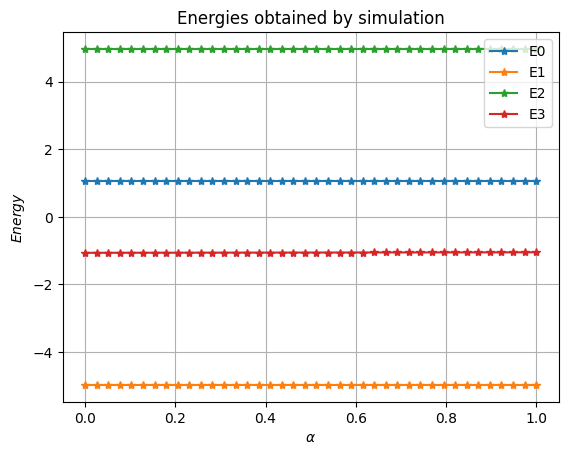

In [106]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies=[]

for value in alpha:
    results_expect, energies_expect,theta=minimize_function(matrizSulfanol,expectation_classic,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

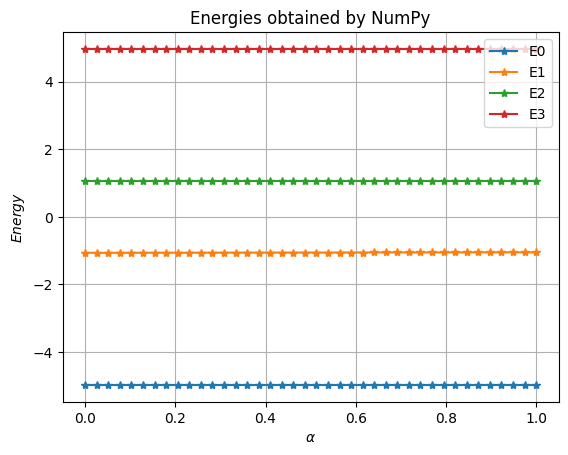

In [108]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies_numpy=[]
for value in alpha:
    energy_numpy=numpy_energies(matrizSulfanol,value)
    energies_numpy.append(energy_numpy)

for i in range(len(energies_numpy[0])):
    plt.plot(alpha, [energies_numpy[j][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by NumPy')
plt.show()

### AB system

In [109]:
betas = [5]

In [110]:
# Construimos H para el sistema AB.
offset=5
B=400
shifts=[1,1.025]
J=[10]
matrizAB=Hspin(shifts,J,offset,B)

\begin{bmatrix}0.41+0.91j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&-1.00-0.06j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&-0.18+0.98j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.79-0.62j\end{bmatrix}

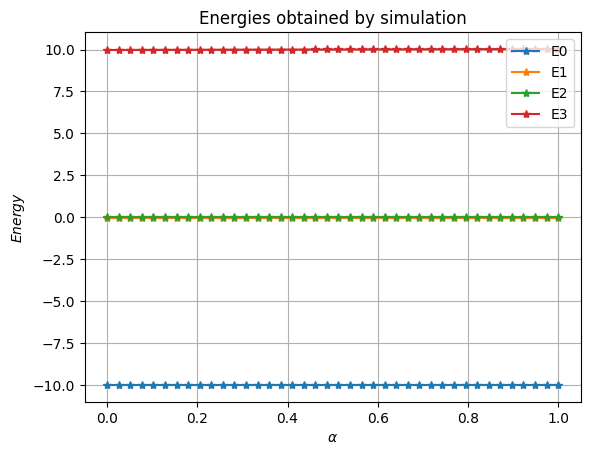

In [111]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies=[]
for value in alpha:
    results_expect, energies_expect,theta=minimize_function(matrizAB,expectation_classic,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


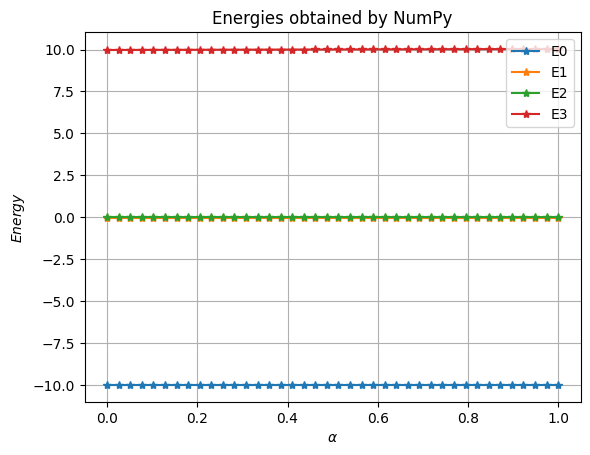

In [112]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies_numpy=[]
for value in alpha:
    energy_numpy=numpy_energies(matrizAB,value)
    energies_numpy.append(energy_numpy)

for i in range(len(energies_numpy[0])):
    plt.plot(alpha, [energies_numpy[j][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by NumPy')
plt.show()

### AX system

In [113]:
betas = [5]

In [114]:
# Construimos H para el sistema AX.
offset=5
B=400
shifts=[1,1.2]
J=[4]
matrizAX=Hspin(shifts,J,offset,B)

\begin{bmatrix}0.38-0.93j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.26+0.96j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.95-0.32j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.56+0.83j\end{bmatrix}

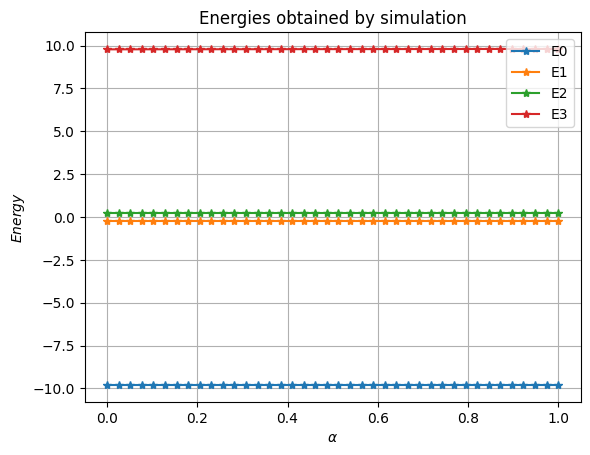

In [115]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies=[]
for value in alpha:
    results_expect, energies_expect,theta=minimize_function(matrizAX,expectation_classic,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


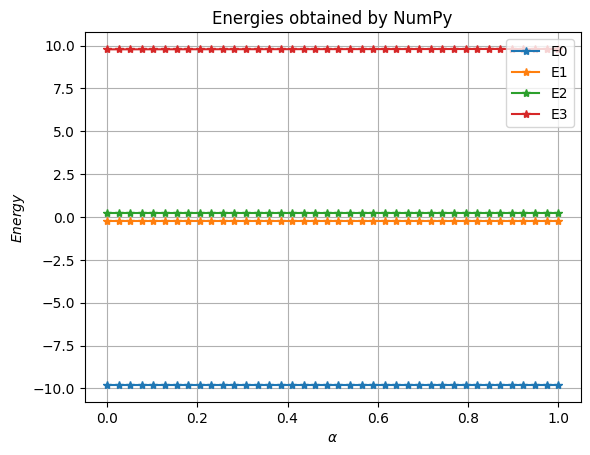

In [116]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies_numpy=[]
for value in alpha:
    energy_numpy=numpy_energies(matrizAX,value)
    energies_numpy.append(energy_numpy)

for i in range(len(energies_numpy[0])):
    plt.plot(alpha, [energies_numpy[j][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by NumPy')
plt.show()

### AMX system

In [117]:
betas = [5]

In [118]:
# Construimos H para el sistema AMX.
offset=5
B=400
shifts=[1,1.2,1.5]
J=[3,10,8]
matrizAMX=Hspin(shifts,J,offset,B)

\begin{bmatrix}0.97-0.26j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&-0.34+0.94j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.92-0.39j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.21+0.98j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.42-0.91j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.99+0.17j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.54-0.84j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&1.00+0.04j\end{bmatrix}

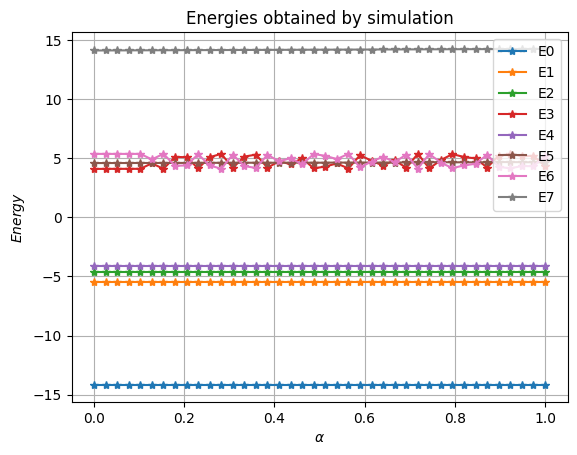

In [119]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies=[]
for value in alpha:
    results_expect, energies_expect,theta=minimize_function(matrizAMX,expectation_classic,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


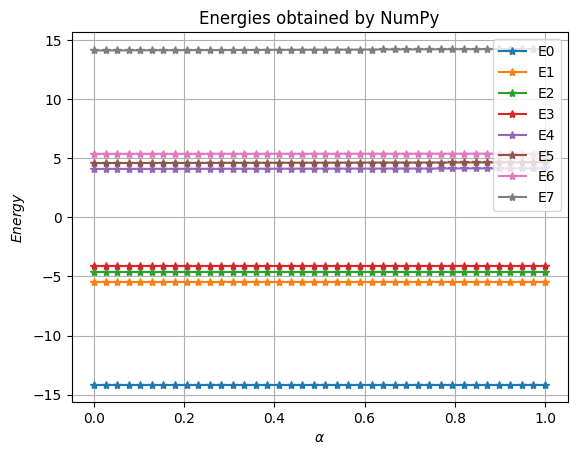

In [120]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies_numpy=[]
for value in alpha:
    energy_numpy=numpy_energies(matrizAMX,value)
    energies_numpy.append(energy_numpy)

for i in range(len(energies_numpy[0])):
    plt.plot(alpha, [energies_numpy[j][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by NumPy')
plt.show()

### ABX system

In [121]:
betas = [5]

In [122]:
# Construimos H para el sistema ABX.
offset=5
B=400
shifts=[1,1.025,1.5]
J=[10,6,4]
matrizABX=Hspin(shifts,J,offset,B)

\begin{bmatrix}-0.31-0.95j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&-0.43-0.90j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&-0.64+0.77j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.52+0.85j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.36-0.93j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.23-0.97j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.98+0.20j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.94+0.33j\end{bmatrix}

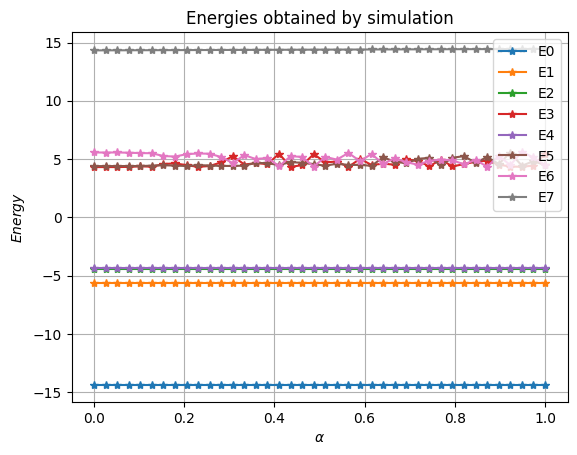

In [123]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies=[]
for value in alpha:
    results_expect, energies_expect,theta=minimize_function(matrizA,expectation_classic,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.title('Energies obtained by simulation')
plt.grid(visible=True)
plt.legend()
plt.show()

C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


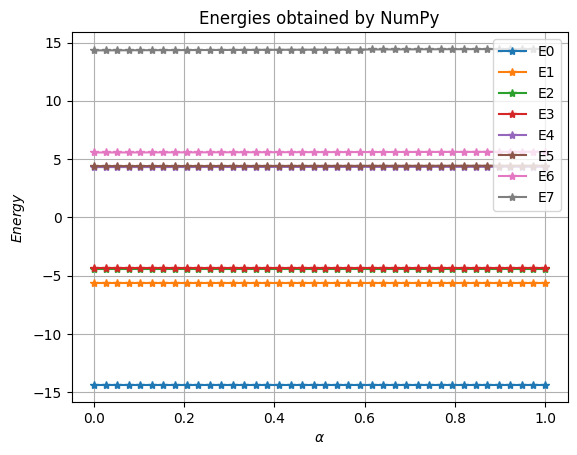

In [124]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies_numpy=[]
for value in alpha:
    energy_numpy=numpy_energies(matrizABX,value)
    energies_numpy.append(energy_numpy)

for i in range(len(energies_numpy[0])):
    plt.plot(alpha, [energies_numpy[j][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.title('Energies obtained by NumPy')
plt.grid(visible=True)
plt.show()

### ABC system

In [125]:
betas = [5]

In [126]:
# Construimos H para el sistema ABC.
offset=5
B=400
shifts=[1,1.025,1.05]
J=[8,10,8]
matrizABC=Hspin(shifts,J,offset,B)

\begin{bmatrix}-0.65+0.76j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&-1.00-0.05j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.45-0.89j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.98-0.18j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.81-0.59j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.96+0.29j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.65+0.76j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&-1.00-0.05j\end{bmatrix}

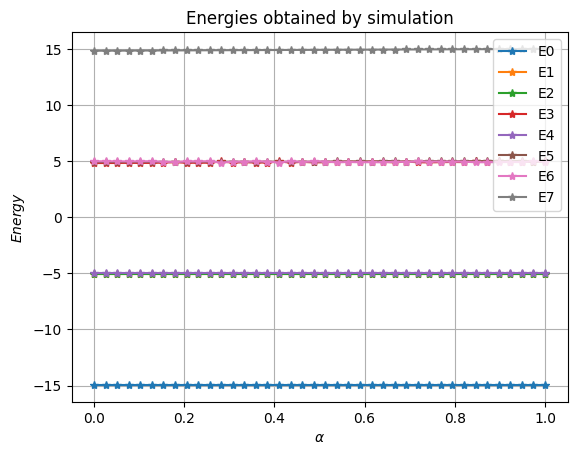

In [127]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies=[]
for value in alpha:
    results_expect, energies_expect=minimize_function(matrizABC,expectation_classic,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


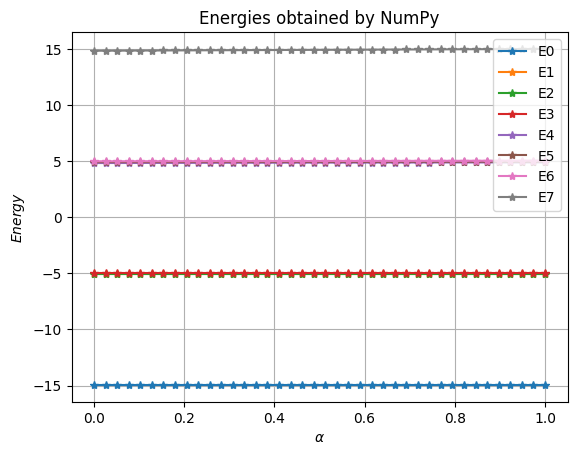

In [128]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies_numpy=[]
for value in alpha:
    energy_numpy=numpy_energies(matrizABC,value)
    energies_numpy.append(energy_numpy)

for i in range(len(energies_numpy[0])):
    plt.plot(alpha, [energies_numpy[j][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by NumPy')
plt.show()

### AMPX system

In [25]:
betas = [0.5]

In [26]:
# Construimos H para el sistema AMPX.
offset=0
B=400
shifts=[1,1.3,2,2.5]
J=[10,7,2,15,9,20]
matrizAMPX=Hspin(shifts,J,offset,B)

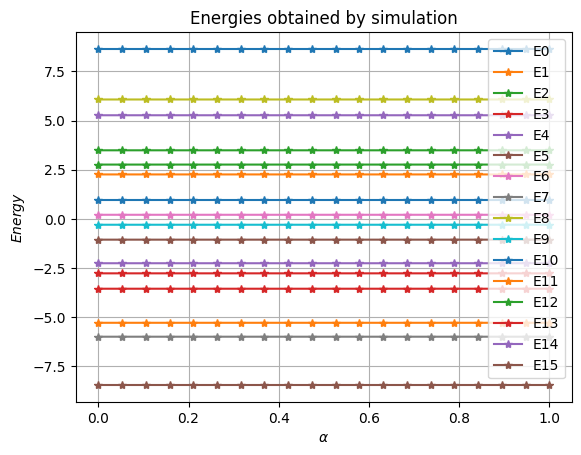

In [27]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,20)
energies=[]
for value in alpha:
    results_expect, energies_expect=minimize_function(matrizAMPX,expectation_classic,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

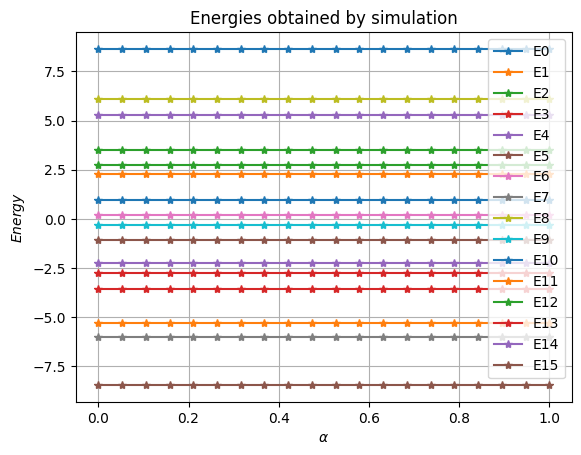

In [28]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,20)
energies=[]
for value in alpha:
    results_expect, energies_expect=minimize_function(matrizAMPX,free_energy,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Cesar\anaconda3\envs\ProyectoMestrelab\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


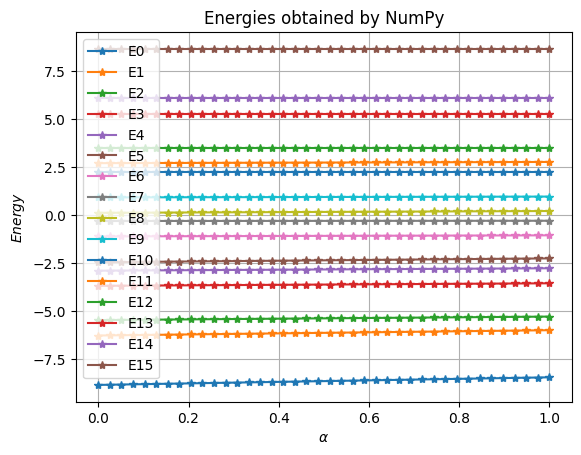

In [132]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies_numpy=[]
for value in alpha:
    energy_numpy=numpy_energies(matrizAMPX,value)
    energies_numpy.append(energy_numpy)

for i in range(len(energies_numpy[0])):
    plt.plot(alpha, [energies_numpy[j][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by NumPy')
plt.show()

### AA'MM'X system

In [29]:
betas = [0.5]

In [30]:
# Construimos H para el sistema AA'MM'X.
offset=4
B=400
shifts=[5,5,5.4,5.4,6]
J=[100,20,25,5,35,30,9,200,40,45]
matrizAA2MM2X=Hspin(shifts,J,offset,B)

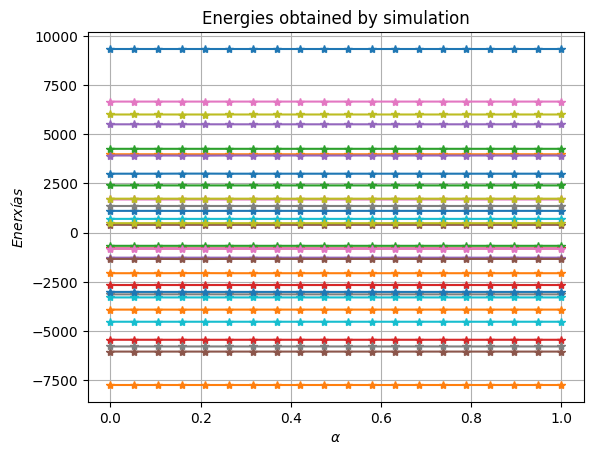

In [34]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,20)
energies=[]
for value in alpha:
    results_expect, energies_expect=minimize_function(matrizAA2MM2X,expectation_classic,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
#plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

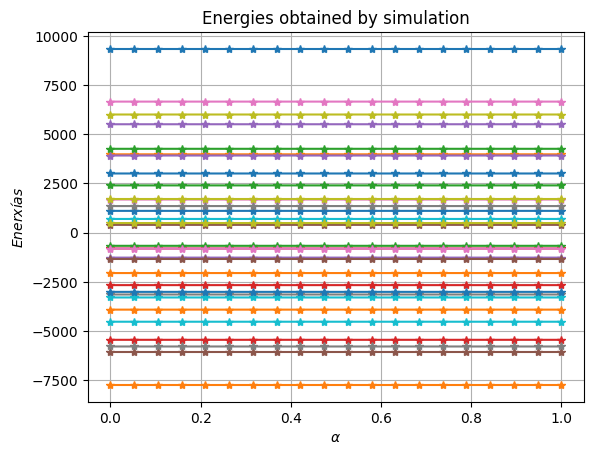

In [35]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,20)
energies=[]
for value in alpha:
    results_expect, energies_expect=minimize_function(matrizAA2MM2X,free_energy,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

In [ ]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,40)
energies_numpy=[]
for value in alpha:
    energy_numpy=numpy_energies(matrizAA2MM2X,value)
    energies_numpy.append(energy_numpy)

for i in range(len(energies_numpy[0])):
    plt.plot(alpha, [energies_numpy[j][i] for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Energy$')
plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by NumPy')
plt.show()

### 5 Spines CN

In [16]:
betas = [0.5]

In [17]:
spins=5
offset=4
B=400
shift0=4.5
shifts=[shift0+i*0.5 for i in range(spins)]
J=250
Jlist=[]
for i in range(spins):
    for j in range(spins-i-1):
        k=i+j+1
        if np.abs(i-k)>3:
            Jik=0
        else:
            Jik=J/((i-k)**2)
        Jlist=Jlist+[Jik]
H=Hspin(shifts,Jlist,offset,B)

In [18]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,20)
energies=[]
for value in alpha:
    results_expect, energies_expect=minimize_function(H,expectation_classic,betas,value)
    energies.append(energies_expect)
    print(value)


0.0
0.05263157894736842
0.10526315789473684
0.15789473684210525
0.21052631578947367
0.2631578947368421
0.3157894736842105
0.3684210526315789
0.42105263157894735
0.47368421052631576
0.5263157894736842
0.5789473684210527
0.631578947368421
0.6842105263157894
0.7368421052631579
0.7894736842105263
0.8421052631578947
0.894736842105263
0.9473684210526315
1.0


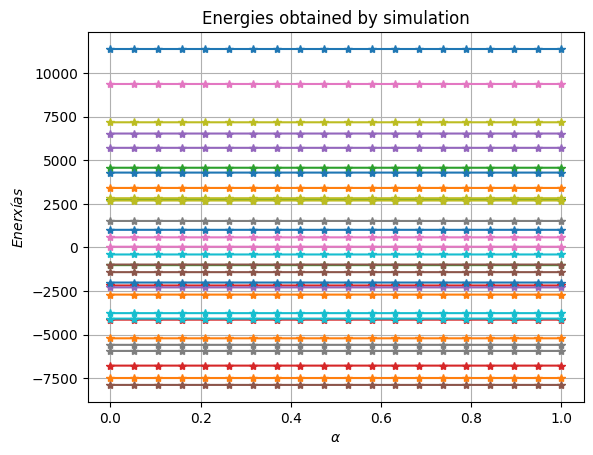

In [19]:
for i in range(32):
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
#plt.legend()
plt.grid(visible=True)
#plt.ylim(3000,6000)
plt.title('Energies obtained by simulation')
plt.show()

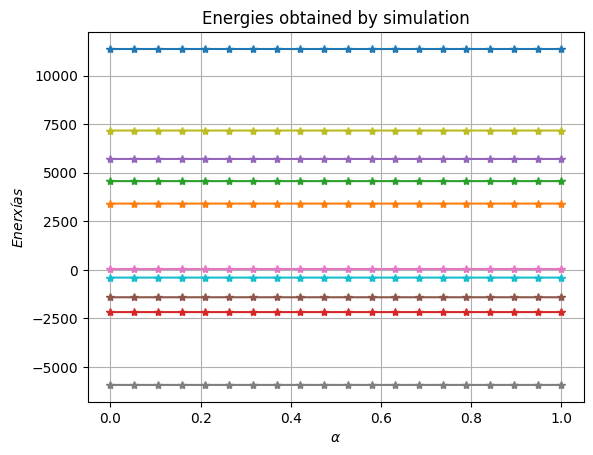

In [20]:
for i in range(10):
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
#plt.legend()
plt.grid(visible=True)
#plt.ylim(3000,6000)
plt.title('Energies obtained by simulation')
plt.show()

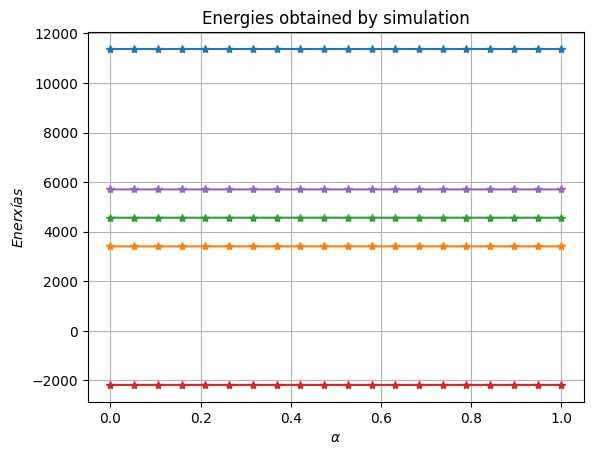

In [21]:
for i in range(5):
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
#plt.legend()
plt.grid(visible=True)
#plt.ylim(3000,6000)
plt.title('Energies obtained by simulation')
plt.show()

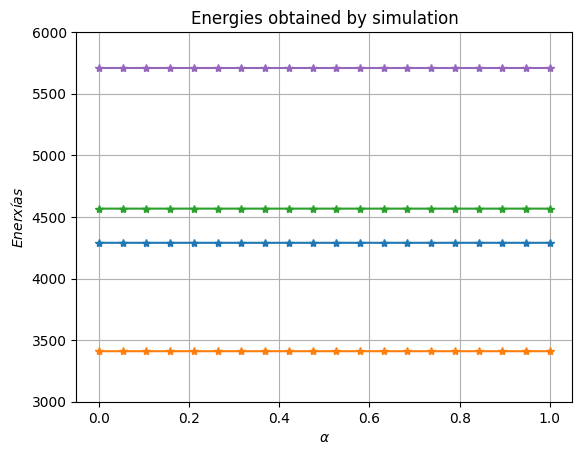

In [22]:
for i in range(32):
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
#plt.legend()
plt.grid(visible=True)
plt.ylim(3000,6000)
plt.title('Energies obtained by simulation')
plt.show()

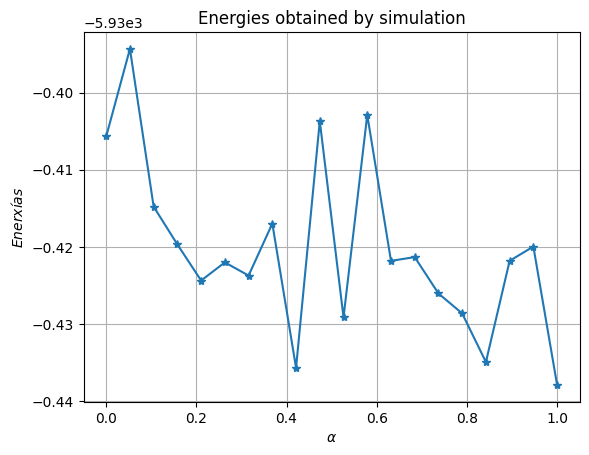

In [23]:
for i in [7]:
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
#plt.legend()
plt.grid(visible=True)
#plt.ylim(3000,6000)
plt.title('Energies obtained by simulation')
plt.show()

In [19]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,20)
energies=[]
for value in alpha:
    results_expect, energies_expect=minimize_function(H,free_energy,betas,value)
    energies.append(energies_expect)



KeyboardInterrupt



In [ ]:
for i in range(5):
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

### 5 Spines CN 2

In [16]:
betas = [0.5]

In [17]:
spins=5
offset=4
B=400
shift0=4.5
shifts=[shift0+i*0.5 for i in range(spins)]
J=500
Jlist=[]
for i in range(spins):
    for j in range(spins-i-1):
        k=i+j+1
        if np.abs(i-k)>3:
            Jik=0
        else:
            Jik=J/((i-k)**2)
        Jlist=Jlist+[Jik]
H=Hspin(shifts,Jlist,offset,B)

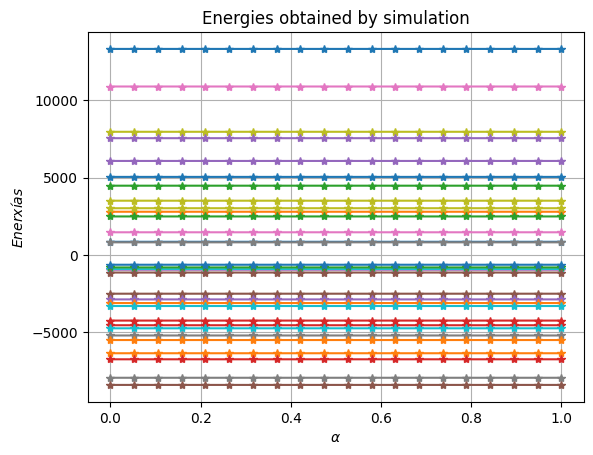

In [18]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,20)
energies=[]
for value in alpha:
    results_expect, energies_expect=minimize_function(H,expectation_classic,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
#plt.legend()
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()

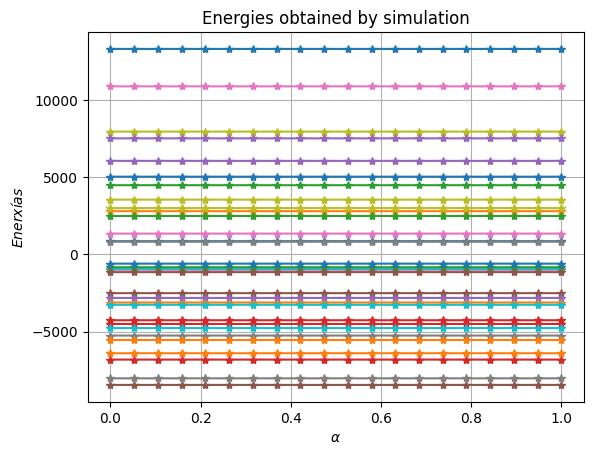

In [19]:
# Representación gráfica de la evolución de las energías con el parámetro alpha, obtenidas mediante la ejecución del algoritmo variacional.
alpha=np.linspace(0,1,20)
energies=[]
for value in alpha:
    results_expect, energies_expect=minimize_function(H,free_energy,betas,value)
    energies.append(energies_expect)

for i in range(len(energies[0][0])):
    plt.plot(alpha, [energies[j][0][i]*factor for j in range(len(alpha))], '*-', label='E'+str(i))

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Enerxías$')
plt.grid(visible=True)
plt.title('Energies obtained by simulation')
plt.show()